In [54]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
from sklearn.neighbors import LSHForest

ImportError: cannot import name 'LSHForest' from 'sklearn.neighbors' (/envs/bluring/lib/python3.7/site-packages/sklearn/neighbors/__init__.py)

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

image ./resources/test4.png loaded
(300, 438)


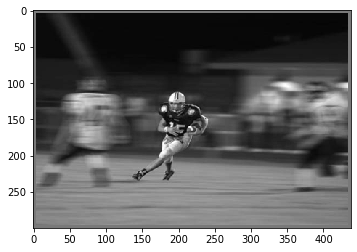

In [13]:
img = utils.loadImage('./resources/test4.png', 'gray')
# x, K = utils.nonUniformBlur(img)
x = img
print(x.shape)
plt.imshow(x, cmap='gray')

In [14]:
def downscale(x, alpha, show=False):
    '''
     @input: blurred img x
     @input: estimated kernel k

     @return: deblurred image
    '''


    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [51]:
"""
imrpove -> predict for the entire row at once, using njobs
intra image reccurence
"""

def getPriorPatch(patch, im_shape, cimg, h):
    k = patch.shape[0]
    
    num = np.zeros((k,k))
    denom = 0
    
    cpatch = patch.ravel()[:,None]
    
    prob = np.exp(-np.mean((cpatch - cimg)**2, axis=0)/(2*(h**2)))
    denom = np.sum(prob)
    num = cimg @ prob[:,None]
    num = num.reshape((k,k))
    
#     for i in range(k//2+1, n-k//2):
#         for j in range(k//2+1, m-k//2):
#             splice = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
#             err = np.mean((patch - splice)**2)
#             exp = -err/(2*(h**2))
            
#             p = np.exp(exp)
#             num += p * splice
#             denom += p
            
    return num/(denom*k*k)

def getPrior(img, patch_size, alpha, h, stride):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    @input h
    @input stride: not used
    
    @return z: size (n x m)
    """
    
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    # build NN model
    cx_alpha = utils.im2col(x_alpha, [M,M])
    model = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', n_jobs=-1)
    model.fit(cx_alpha.T, np.arange(cx_alpha.shape[1]))
    
    z = np.zeros(img.shape)
    
    cimg = utils.im2col(img, [M,M])
    predictions = cx_alpha[:, model.predict(cimg.T)]
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
            prior = predictions[:, (i-M//2)*(m-2*(M//2)) + (j-M//2)].reshape((M,M))/(M*M)
#             prior = getPriorPatch(patch, x_alpha.shape, cimg, h)
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += prior
    return z

In [52]:
z = getPrior(x, 21, 4/3, 10, 1)

AttributeError: module 'sklearn.neighbors' has no attribute 'LSHForest'

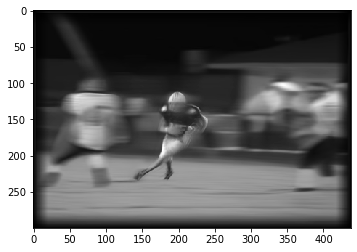

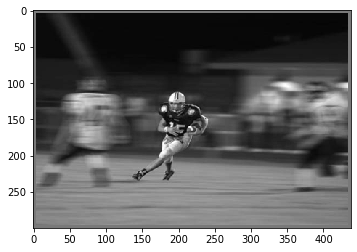

In [47]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')

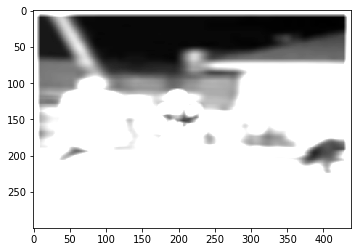

In [48]:
k = 1/25*np.ones((5,5))
cv2.filter2D(x,-1, k)
plt.imshow(cv2.filter2D(x, -1, 1/25*np.ones((11,11))), cmap='gray')

In [ ]:
def EPLLhalfQuadraticSplitDeblur(noiseI,lam,K,patchSize,betas,T,prior,I,LogLFunc):
    RealNoiseSD = np.sqrt(1/(lam[1]/patchSize^2))
#     if expecting cost
    calc_cost = False
    cost = []
    beta = np.abs(betas[1]/4)
    cleanI = noiseI
    k=1
    sd = float('inf')
    for betaa in betas:
#         if any beta<0 estimate betas automatically
        if betaa<0:
            old_sd = sd
            [sd] = estimateNoiseSDUsingKurts(cleanI,12)
#             fprintf('sd is:%f beta is %f * (1/noiseSD^2)',sd,(1/sd^2)/(1/RealNoiseSD^2));
            sd = sd
            if np.isnan(sd) or sd>old_sd:
                beta = beta*4
                sd = np.power(beta, -0.5)
            else:
                beta = 1/sd**2
        else
            beta = betaa
        for tt in range(1, T):
#             Z step
#             Z = utils.im2col(cleanI,[patchSize, patchSize]);

#             calculate orignal cost if LogLFunc is defined and output
#             arguments expect it
            if calc_cost:
                cost[k] = 0.5*lam@np.sum(np.power(cleanI.ravel()- noiseI.ravel(),2)) - EPLL(Z,LogLFunc);
            
            
# ---------------------------------add prior here------------------------------------------------------
#             cleanZ = prior(Z,patchSize,(beta)^-0.5,size(noiseI));

#------------------------------------------------------------------------------------------------------


#             x step
            I1 = cleanZ
#             I1, counts = scol2im(cleanZ, patchSize, I.shape[0], I.shape[1], 'sum')

            tt1 = noiseI[(K.shape[0]//2)+1:end-K.shape[0]//2,(K.shape[1]//2) +1:end-K.shape[1]//2];
#             convolution with the rotated kernel (LHS of Equation 4 in the
#             paper)
            tt1 = convolve2d(tt1, np.rot90(np.rot90(K)), 'full');
            tt2 = I1;


#             Solve for x, using the convolved image from above (Equation 4 in
#             the paper)
            cleanI = bicg()
            cleanI = np.reshape(cleanI, noiseI.shape)
#             cleanI = reshape(bicg(@(x,tflag) Afun(x,K,counts,beta,lam,size(I),tflag),(lam*tt1(:) + beta*tt2(:)),1e-6,2500),size(noiseI));

#             psnr(k) = 20*log10(1/std2(cleanI-I));

#             fprintf('PSNR is:%f I1 PSNR:%f\n',psnr(k),20*log10(1/std2(I1./counts-I)));
#              imshow([I noiseI cleanI],[0 1]); drawnow;
            k=k+1;  

In [ ]:
function [cleanI,psnr,cost] = EPLLhalfQuadraticSplitDeblur(noiseI,lambda,K,patchSize,betas,T,prior,I,LogLFunc)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
% EPLLhalfQuadraticSplitDeblur - Minimizes the EPLL cost using half quadratic splitting
% as defined in the paper:
% "From Learning Models of Natural Image Patches to Whole Image Restoration"
% by Daniel Zoran and Yair Weiss, ICCV 2011
% 
% 
% Version 1.0 (21/10/2011)
%
% This function is for deblurring, for denoising and inpainting - for deblurring refer to
% EPLLhalfQuadraticSplit.m
%
%
% Inputs:
%
%   noiseI - the blurry image, with some noise added to it
%   lambda - the parameter lambda from Equation (2) in the paper (mostly
%            used as the inverse of the noise variance. If a matrix is given, it
%            should be the same size as the image (used for inpainting)
%   K - the blur kernel used to blur the image
%   patchSize - the size of patches to extract (single scalar, patches are
%               always square)
%   betas - a list (1xM vector) of beta values, if the values are positive, they will be
%           used as is, negative values will be ignored and beta will be estimated
%           automatically from the noisy image (for as many iterations as there are
%           in betas)
%   T - The number of iterations to optimizie for X and Z at each beta
%       value
%   prior - a function handle to a function which calculates a MAP estimate
%           using a given prior for a noisy patch at noise level beta, see examples in the
%           demos
%   I - the original image I, used only for PSNR calculations and
%       comparisons
%   LogLFunc - a function handle to calculate the log likelihood of patches
%              in the image, used for calculating the total cost (optional).
%
%
%
% Outputs:
%
%   cleanI - the restored image
%   psnr - a list of the psnr values obtained for each beta and iteration
%   cost - if LogLFunc is given then this is the cost from Equation 2 in
%          the paper at each value of beta.
%
% See demos in this same code package for examples on how to use this
% function for deblurring some example priors
% (including the GMM prior used in the paper).
%
% All rights reserved to the authors of the paper (Daniel Zoran and Yair
% Weiss). If you have any questions, comments or suggestions please contact
% Daniel Zoran at daniez@cs.huji.ac.il.
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


%%%%%%%%%%%%%%%%%%%%%%%
% This function is practically identical to EPLLhalfQuadraticSplit, which
% you should refer to for detailed documentaion. The only difference is
% with the handling of the blurring kernel, which is documented below.
%%%%%%%%%%%%%%%%%%%%%%

RealNoiseSD = sqrt(1/(lambda(1)/patchSize^2));
% if expecting cost
calc_cost = false;
cost = [];
if nargout>2
    if isa(LogLFunc,'function_handle')
        calc_cost = true;
    else
        calc_cost = false;
    end
end
% TT = myconvmtx2(noiseI,K);

beta = abs(betas(1)/4);
cleanI = noiseI;
k=1;
sd = Inf;
for betaa=betas
    % if any beta<0 estimate betas automatically
    if (betaa<0)
        old_sd = sd;
        [sd] = estimateNoiseSDUsingKurts(cleanI,12);
        fprintf('sd is:%f beta is %f * (1/noiseSD^2)',sd,(1/sd^2)/(1/RealNoiseSD^2));
        sd = sd;
        if isnan(sd) || sd>old_sd
            beta = beta*4;
            sd = beta^-0.5;
        else
            beta = 1/sd^2;
        end
    else
        beta = betaa;
    end
    
    for tt=1:T
        % Z step
        Z = im2col(cleanI,[patchSize patchSize]);

        % calculate orignal cost if LogLFunc is defined and output
        % arguments expect it
        if calc_cost
            cost(k) = 0.5*lambda*sum((cleanI(:)-noiseI(:)).^2) - EPLL(Z,LogLFunc);
            fprintf('Cost is: %f\n',cost(k));
        end
        
        cleanZ = prior(Z,patchSize,(beta)^-0.5,size(noiseI));
        
        % x step
        [I1,counts] = scol2im(cleanZ,patchSize,size(I,1),size(I,2),'sum');

        tt1 = noiseI(floor(size(K,1)/2)+1:end-floor(size(K,1)/2),floor(size(K,2)/2)+1:end-floor(size(K,2)/2));
        % convolution with the rotated kernel (LHS of Equation 4 in the
        % paper)
        tt1 = conv2(tt1,rot90(rot90(K)),'full');
        tt2 = I1;

        
        % Solve for x, using the convolved image from above (Equation 4 in
        % the paper)
        cleanI = reshape(bicg(@(x,tflag) Afun(x,K,counts,beta,lambda,size(I),tflag),(lambda*tt1(:) + beta*tt2(:)),1e-6,2500),size(noiseI));

        psnr(k) = 20*log10(1/std2(cleanI-I));
        
        fprintf('PSNR is:%f I1 PSNR:%f\n',psnr(k),20*log10(1/std2(I1./counts-I)));
%         imshow([I noiseI cleanI],[0 1]); drawnow;
        k=k+1;      
    end
end
        
cleanI = reshape(cleanI,size(noiseI));
cleanI(cleanI>1)=1;
cleanI(cleanI<0)=0;
psnr = psnr(:)';

% function to apply the corruption model (implemented efficiantly using
% convolutions instead of matrix multiplications)
function y = Afun(x,K,counts,beta,lambda,ss,transp_flag)
xx = reshape(x,ss);
tt = imfilter(xx,K,'conv','same');
tt = tt(floor(size(K,1)/2)+1:end-floor(size(K,1)/2),floor(size(K,2)/2)+1:end-floor(size(K,2)/2));
y = lambda*imfilter(tt,rot90(rot90(K)),'conv','full');
y = y + beta*counts.*xx;
y = y(:);
